#### Load in our helper functions:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix, csr_matrix

#### Load our hybrid recommender system class:

In [ ]:


class HybridRecommender:
    """
    A hybrid recommendation system combining Collaborative Filtering (ALS) and Content-Based Filtering (TF-IDF + ANN).
    """
    
    def __init__(self):
        """Initialize the recommender with empty attributes."""
        self.als_model = None
        self.tfidf_matrix = None
        self.nbrs = None
        self.user_id_to_idx = {}
        self.movie_id_to_idx = {}
        self.movie_id_to_index = {}
        self.user_rated_movies = {}
        self.movies_df = None
        self.train_ratings = None
        self.test_ratings = None
        self.distances = None
        self.indices = None

    def train_test_split(self, ratings_df: pd.DataFrame, min_train_ratings: int = 1) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Split ratings data into training and testing sets per user.

        Args:
            ratings_df : pd.DataFrame : DataFrame with columns ['userId', 'movieId', 'rating']
            min_train_ratings : int : Minimum ratings per user in training set (default: 1)

        Returns:
            tuple : (train_ratings: pd.DataFrame, test_ratings: pd.DataFrame)
        """
        train_ratings_list = []
        test_ratings_list = []

        for user_id in tqdm(ratings_df['userId'].unique(), desc="Splitting data"):
            user_ratings = ratings_df[ratings_df['userId'] == user_id]
            num_ratings = len(user_ratings)

            if num_ratings <= min_train_ratings:
                train_user_ratings = user_ratings
                test_user_ratings = pd.DataFrame(columns=user_ratings.columns)
            elif num_ratings <= 4:
                train_user_ratings, test_user_ratings = train_test_split(user_ratings, test_size=1, random_state=42)
            else:
                test_size = max(2, int(0.3 * num_ratings))
                train_user_ratings, test_user_ratings = train_test_split(user_ratings, test_size=test_size, random_state=42)
            
            train_ratings_list.append(train_user_ratings)
            test_ratings_list.append(test_user_ratings)

        self.train_ratings = pd.concat(train_ratings_list, ignore_index=True)
        self.test_ratings = pd.concat(test_ratings_list, ignore_index=True)

    def collaborativeFiltering(self, factors: int = 50, iterations: int = 20, regularization: float = 0.1) -> None:
        """
        Train an ALS model for collaborative filtering on training ratings.

        Args:
            factors : int : Number of latent factors (default: 50)
            iterations : int : Number of ALS iterations (default: 20)
            regularization : float : Regularization parameter (default: 0.1)
        """
        # Create sparse user-movie matrix
        user_ids = self.train_ratings['userId'].astype('category').cat.codes
        movie_ids = self.train_ratings['movieId'].astype('category').cat.codes
        ratings = self.train_ratings['rating'].values

        sparse_matrix = coo_matrix((ratings, (user_ids, movie_ids)))
        self.als_model = AlternatingLeastSquares(factors=factors, iterations=iterations, regularization=regularization)
        self.als_model.fit(sparse_matrix)

        # Store mappings
        self.user_id_to_idx = dict(zip(self.train_ratings['userId'].astype('category').cat.categories, 
                                       range(len(self.train_ratings['userId'].unique()))))
        self.movie_id_to_idx = dict(zip(self.train_ratings['movieId'].astype('category').cat.categories, 
                                        range(len(self.train_ratings['movieId'].unique()))))

    def contentbasedFiltering(self, movies_df: pd.DataFrame, max_tfidf_features: int = 500, n_neighbors: int = 50) -> None:
        """
        Build a content-based model using TF-IDF and Approximate Nearest Neighbors.

        Args:
            movies_df : pd.DataFrame : DataFrame with movie features ['id', 'genres', 'overview', 'Director', 'keywords']
            max_tfidf_features : int : Max number of TF-IDF features (default: 500)
            n_neighbors : int : Number of neighbors for ANN (default: 50)
        """
        self.movies_df = movies_df.copy()
        valid_movie_ids = set(self.train_ratings['movieId']).union(set(self.test_ratings['movieId']))
        self.movies_df = self.movies_df[self.movies_df['id'].isin(valid_movie_ids)].reset_index(drop=True)

        # Preprocess text features
        def preprocess_text(text): return ' '.join(str(text).lower().split()) if pd.notna(text) else ''
        self.movies_df['genres_processed'] = self.movies_df['genres'].fillna('').str.lower().str.split(', ').apply(lambda x: ' '.join(sorted(set(x))))
        self.movies_df['overview_processed'] = self.movies_df['overview'].apply(preprocess_text)
        self.movies_df['directors_processed'] = self.movies_df['Director'].apply(preprocess_text)
        self.movies_df['keywords_processed'] = self.movies_df['keywords'].apply(preprocess_text)
        self.movies_df['combined_features'] = (self.movies_df['genres_processed'] + ' ' +
                                               self.movies_df['overview_processed'] + ' ' +
                                               self.movies_df['directors_processed'] + ' ' +
                                               self.movies_df['keywords_processed']).str.strip()

        # TF-IDF
        tfidf = TfidfVectorizer(stop_words='english', max_features=max_tfidf_features)
        self.tfidf_matrix = tfidf.fit_transform(self.movies_df['combined_features'])
        self.tfidf_matrix = csr_matrix(self.tfidf_matrix)
        norms = np.sqrt((self.tfidf_matrix.power(2)).sum(axis=1).A.ravel())
        tfidf_matrix_normalized = self.tfidf_matrix.multiply(1 / norms[:, np.newaxis])

        # ANN
        self.nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='euclidean')
        self.nbrs.fit(tfidf_matrix_normalized)
        self.distances, self.indices = self.nbrs.kneighbors(tfidf_matrix_normalized, n_neighbors=n_neighbors)

        # Movie ID to index mapping
        self.movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(self.movies_df['id'])}

    def precompute_mappings(self) -> None:
        """
        Precompute user-rated movies for efficiency in predictions.
        """
        self.user_rated_movies = {user_id: self.train_ratings[self.train_ratings['userId'] == user_id]['movieId'].values 
                                  for user_id in tqdm(self.train_ratings['userId'].unique(), desc="Precomputing user-rated movies")}

    def hybrid_predict4Benchmarking(self, user_id: int, movie_id: int) -> tuple[float, float]:
        """
        Predict CF and CB scores separately for benchmarking purposes (no alpha blending).

        Args:
            user_id : int : User ID
            movie_id : int : Movie ID

        Returns:
            tuple : (cf_score: float, cb_score: float) - Collaborative and Content-Based scores
        """
        # CF score
        user_idx = self.user_id_to_idx.get(user_id, -1)
        movie_idx = self.movie_id_to_idx.get(movie_id, -1)
        if user_idx == -1 or movie_idx == -1:
            cf_score = 0
        else:
            cf_score = self.als_model.user_factors[user_idx].dot(self.als_model.item_factors[movie_idx])
            cf_score = np.clip(cf_score, 0, 5)

        # CB score
        user_movies = self.user_rated_movies.get(user_id, np.array([]))
        if len(user_movies) == 0:
            cb_score = 0
        else:
            movie_idx = self.movie_id_to_index.get(movie_id, -1)
            if movie_idx != -1:
                movie_neighbors = self.indices[movie_idx]
                movie_distances = self.distances[movie_idx]
                liked_indices = np.array([self.movie_id_to_index.get(m, -1) for m in user_movies])
                valid_mask = (liked_indices != -1) & np.isin(liked_indices, movie_neighbors)
                valid_liked_indices = liked_indices[valid_mask]
                if len(valid_liked_indices) > 0:
                    neighbor_positions = np.searchsorted(movie_neighbors, valid_liked_indices)
                    valid_positions = neighbor_positions[neighbor_positions < len(movie_neighbors)]
                    if len(valid_positions) > 0:
                        euclidean_dists = movie_distances[valid_positions]
                        sim_scores = 1 - (euclidean_dists**2) / 2
                        cb_score = 5 * np.mean(sim_scores)
                    else:
                        cb_score = 0
                else:
                    cb_score = 0
            else:
                cb_score = 0
        cb_score = np.clip(cb_score, 0, 5)

        return cf_score, cb_score

    def hybrid_predict(self, user_id: int, movie_id: int, alpha: float = 0.5) -> float:
        """
        Predict a final hybrid score by blending CF and CB scores with alpha.

        Args:
            user_id : int : User ID
            movie_id : int : Movie ID
            alpha : float : Weight for CF score (1-alpha for CB), between 0 and 1 (default: 0.5)

        Returns:
            float : Final hybrid prediction score
        """
        cf_score, cb_score = self.hybrid_predict4Benchmarking(user_id, movie_id)
        return alpha * cf_score + (1 - alpha) * cb_score

    def fit(self, ratings_df: pd.DataFrame, movies_df: pd.DataFrame) -> None:
        """
        Fit the hybrid recommender model by running all steps.

        Args:
            ratings_df : pd.DataFrame : Ratings data
            movies_df : pd.DataFrame : Movie metadata
        """
        self.train_test_split(ratings_df)
        self.collaborativeFiltering()
        self.contentbasedFiltering(movies_df)
        self.precompute_mappings()

        return self.train_ratings, self.test_ratings



#### About the HybridRecommender Class
The HybridRecommender class is a custom class we made that combines Collaborative Filtering (CF) using Alternating Least Squares (ALS) and Content-Based Filtering (CBF) using TF-IDF and Approximate Nearest Neighbors (ANN) to provide movie recommendations.

**Key Methods:**

_train_test_split(ratings_df, min_train_ratings):_
- Splits the ratings data into training and testing sets for each user. collaborativeFiltering(factors, iterations, regularization):
- Trains a collaborative filtering model using ALS on the training data.

_contentbasedFiltering(movies_df, max_tfidf_features, n_neighbors):_

- Builds a content-based model using TF-IDF vectorization on movie metadata (genres, overview, directors, keywords) and finds similar movies using ANN.

_precompute_mappings():_
- Precomputes the movies rated by each user for faster prediction during hybrid recommendation.

_hybrid_predict4Benchmarking(user_id, movie_id):_
- Predicts the scores from CF and CBF models separately, for benchmarking purposes.

_hybrid_predict(user_id, movie_id, alpha):_
- Combines CF and CBF predictions into a final hybrid score, weighted by alpha.

_fit(ratings_df, movies_df):_
- Runs the entire pipeline: splits data, trains CF and CBF models, and prepares for predictions.


#### Train Test Split + Train

In [3]:
# Load and preprocess data
ratings_df = pd.read_csv('filtered_ratings.csv')
movies_df = pd.read_csv('filtered_movies_with_weighted.csv')
movies_df['id'] = movies_df['id'].astype(int)
ratings_df['movieId'] = ratings_df['movieId'].astype(int)
valid_movie_ids = set(movies_df['id'])
ratings_df = ratings_df[ratings_df['movieId'].isin(valid_movie_ids)]
print(f"Number of ratings after filtering: {len(ratings_df)}")

# Initialize and fit the model
recommender = HybridRecommender()
train_ratings, test_ratings = recommender.fit(ratings_df, movies_df)

# Print split statistics
train_user_ids = train_ratings['userId'].unique()
test_user_ids = test_ratings['userId'].unique()
users_with_no_train_ratings = set(test_user_ids) - set(train_user_ids)
if users_with_no_train_ratings:
    print(f"Warning: Found {len(users_with_no_train_ratings)} users in test_user_ids with no ratings in train_ratings: {users_with_no_train_ratings}")
else:
    print("All test users have at least one rating in train_ratings.")
print(f"Total users: {len(ratings_df['userId'].unique())}")
print(f"Training users: {len(train_user_ids)}")
print(f"Testing users: {len(test_user_ids)}")
print(f"Training ratings: {len(train_ratings)}")
print(f"Testing ratings: {len(test_ratings)}")
total_ratings = len(ratings_df)
train_proportion = len(train_ratings) / total_ratings
test_proportion = len(test_ratings) / total_ratings
print(f"Training proportion: {train_proportion:.4f} (should be ~0.7)")
print(f"Testing proportion: {test_proportion:.4f} (should be ~0.3)")

Number of ratings after filtering: 2870775


Precomputing user-rated movies: 100%|██████████| 103839/103839 [02:42<00:00, 639.23it/s]


All test users have at least one rating in train_ratings.
Total users: 103839
Training users: 103839
Testing users: 103839
Training ratings: 2055925
Testing ratings: 814850
Training proportion: 0.7162 (should be ~0.7)
Testing proportion: 0.2838 (should be ~0.3)


#### Validate distrubution of Train and Test data

In [4]:
train_ratings.describe().round(2)

,userId,movieId,rating,timestamp
count,2055925.00,2055925.00,2055925.00,2.055925e+06
mean,135005.84,7483.07,3.57,1.103613e+09
std,78010.16,18762.20,1.07,2.118278e+08
min,4.00,2.00,0.50,7.896520e+08
25%,67502.00,457.00,3.00,9.396662e+08
50%,135142.00,1380.00,4.00,1.077215e+09
75%,202303.00,3114.00,4.00,1.266936e+09
max,270896.00,169864.00,5.00,1.501827e+09


In [5]:
test_ratings.describe().round(2)

,userId,movieId,rating,timestamp
count,814850.00,814850.00,814850.00,8.148500e+05
mean,134993.73,7445.12,3.57,1.099963e+09
std,78012.01,18960.03,1.07,2.111077e+08
min,4.00,2.00,0.50,8.228736e+08
25%,67497.00,457.00,3.00,9.389828e+08
50%,135126.50,1365.00,4.00,1.071638e+09
75%,202302.00,3072.00,4.00,1.260811e+09
max,270896.00,169864.00,5.00,1.501827e+09


#### Pre-compute test data:

In [6]:
# Evaluate on test ratings
start = time.time()
user_test_predictions = {}
for _, row in tqdm(test_ratings.iterrows(), total=len(test_ratings), desc="Evaluating test ratings"):
    user_id = row['userId']
    movie_id = row['movieId']
    actual_rating = row['rating']
    cf_score, cb_score = recommender.hybrid_predict4Benchmarking(user_id, movie_id)
    if user_id not in user_test_predictions:
        user_test_predictions[user_id] = []
    user_test_predictions[user_id].append((movie_id, cf_score, cb_score, actual_rating))
print(f"Evaluation Time: {time.time() - start:.2f} seconds")

Evaluating test ratings: 100%|██████████| 814850/814850 [01:23<00:00, 9723.43it/s] 

Evaluation Time: 83.80 seconds


#### Evaluate the distribution of prediction scores from both models:
- to ensure both scores are in between ranges of 1-5

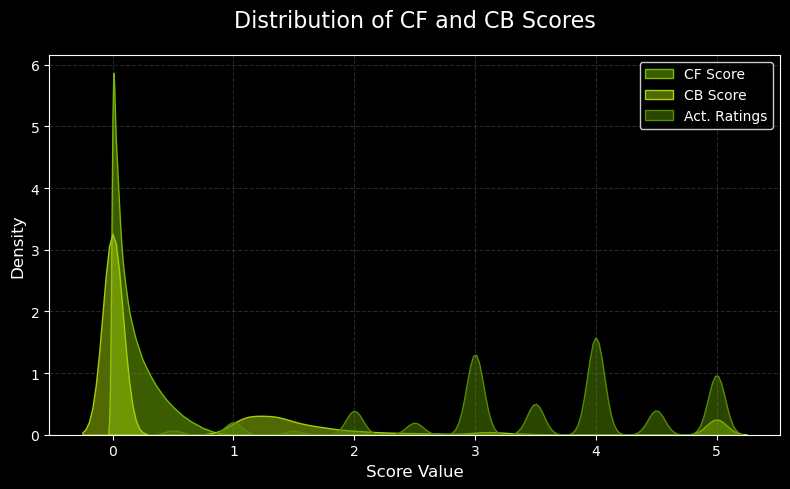

CF Score - Min: 0.00, Max: 1.31, Mean: 0.18
CB Score - Min: 0.00, Max: 5.00, Mean: 0.69
Actual Ratings - Min: 0.50, Max: 5.00, Mean: 3.57


In [7]:
# Extract scores for visualization
cf_scores = []
cb_scores = []
actual_rates = []
for user_id, preds in user_test_predictions.items():
    for _, cf_score, cb_score, actual_rating in preds:
        cf_scores.append(cf_score)
        cb_scores.append(cb_score)
        actual_rates.append(actual_rating)

# Plot distributions
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 5))
nvidia_green = '#76B900'
nvidia_light_green = '#A4D007'
nvidia_dark_green = '#558B00'
sns.kdeplot(cf_scores, ax=ax, color=nvidia_green, label='CF Score', fill=True, alpha=0.5)
sns.kdeplot(cb_scores, ax=ax, color=nvidia_light_green, label='CB Score', fill=True, alpha=0.5)
sns.kdeplot(actual_rates, ax=ax, color=nvidia_dark_green, label='Act. Ratings', fill=True, alpha=0.5)
ax.set_title('Distribution of CF and CB Scores', fontsize=16, color='white', pad=20)
ax.set_xlabel('Score Value', fontsize=12, color='white')
ax.set_ylabel('Density', fontsize=12, color='white')
ax.tick_params(axis='both', colors='white')
ax.grid(True, linestyle='--', alpha=0.3, color='gray')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
ax.legend(facecolor='black', edgecolor='white', fontsize=10, labelcolor='white')
plt.tight_layout()
plt.show()

# Print statistics
print(f"CF Score - Min: {min(cf_scores):.2f}, Max: {max(cf_scores):.2f}, Mean: {np.mean(cf_scores):.2f}")
print(f"CB Score - Min: {min(cb_scores):.2f}, Max: {max(cb_scores):.2f}, Mean: {np.mean(cb_scores):.2f}")
print(f"Actual Ratings - Min: {min(actual_rates):.2f}, Max: {max(actual_rates):.2f}, Mean: {np.mean(actual_rates):.2f}")

From above, we can see that the model isn't perfect, there are still ratings not being recommended properly. This is an issue that can be improved in the future.

#### Define precision/recall@k evaluation function:

In [8]:
# Define evaluation function
def precision_recall_at_k(user_test_predictions, user_rated_movies, alpha=0.5, k=5, threshold=3.5):
    precision_sum = 0
    recall_sum = 0
    num_users = 0
    all_predictions = []
    all_actuals = []
    for user_id, preds in tqdm(user_test_predictions.items(), desc=f"Computing Metrics (alpha={alpha})"):
        hybrid_preds = [(movie_id, alpha * cf_score + (1 - alpha) * cb_score, actual_rating)
                        for movie_id, cf_score, cb_score, actual_rating in preds]
        hybrid_preds.sort(key=lambda x: x[1], reverse=True)
        top_k = hybrid_preds[:k]
        top_k_movie_ids = set(x[0] for x in top_k)
        relevant_movies = set(x[0] for x in hybrid_preds if x[2] >= threshold)
        if not relevant_movies:
            continue
        train_rated = set(user_rated_movies.get(user_id, []))
        recommended = top_k_movie_ids - train_rated
        relevant_and_recommended = recommended.intersection(relevant_movies)
        precision = len(relevant_and_recommended) / k if k > 0 else 0
        recall = len(relevant_and_recommended) / len(relevant_movies) if relevant_movies else 0
        precision_sum += precision
        recall_sum += recall
        num_users += 1
        hybrid_scores = [x[1] for x in hybrid_preds]
        actual_ratings = [x[2] for x in hybrid_preds]
        all_predictions.extend(hybrid_scores)
        all_actuals.extend(actual_ratings)
    avg_precision = precision_sum / num_users if num_users > 0 else 0
    avg_recall = recall_sum / num_users if num_users > 0 else 0
    rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions)) if all_actuals else 0
    return avg_precision, avg_recall, rmse


#### Compare performance of model against various alpha values
---
- What is alpha?
    
    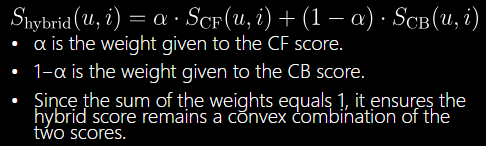
    - As alpha increases, the hybrid model favours the results from the collaborative model/ALS model.

Computing Metrics (alpha=0.0): 100%|██████████| 103839/103839 [00:01<00:00, 83468.59it/s]


Alpha: 0.0
Precision@5: 0.8180
Recall@5: 0.7070
RMSE: 3.3365



Computing Metrics (alpha=0.25): 100%|██████████| 103839/103839 [00:01<00:00, 84264.90it/s]


Alpha: 0.25
Precision@5: 0.8266
Recall@5: 0.7147
RMSE: 3.3392



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 83203.67it/s]


Alpha: 0.5
Precision@5: 0.8269
Recall@5: 0.7149
RMSE: 3.3771



Computing Metrics (alpha=1.0): 100%|██████████| 103839/103839 [00:01<00:00, 84712.84it/s]


Alpha: 1.0
Precision@5: 0.8357
Recall@5: 0.7203
RMSE: 3.5528



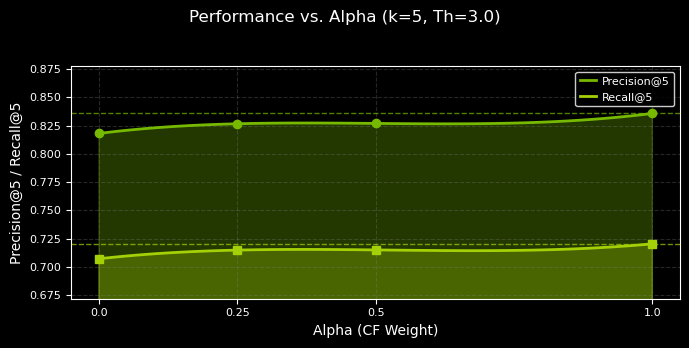

In [9]:
# Benchmark with different alpha values
alpha_values = [0.0, 0.25, 0.5, 1.0]
precision_values = []
recall_values = []
rmse_values = []
for alpha in alpha_values:
    precision_at_5, recall_at_5, rmse = precision_recall_at_k(user_test_predictions, recommender.user_rated_movies, alpha=alpha, k=5, threshold=3.0)
    print(f"Alpha: {alpha}")
    print(f"Precision@5: {precision_at_5:.4f}")
    print(f"Recall@5: {recall_at_5:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print()
    precision_values.append(precision_at_5)
    recall_values.append(recall_at_5)

# Plot alpha performance
alpha_values = np.array(alpha_values)
precision_values = np.array(precision_values)
recall_values = np.array(recall_values)
alpha_fine = np.linspace(min(alpha_values), max(alpha_values), 100)
spline_precision = make_interp_spline(alpha_values, precision_values, k=3)
spline_recall = make_interp_spline(alpha_values, recall_values, k=3)
precision_smooth = spline_precision(alpha_fine)
recall_smooth = spline_recall(alpha_fine)
all_values = np.concatenate([precision_values, recall_values])
y_min = min(all_values) * 0.95
y_max = min(max(all_values) * 1.05, 1.0)
max_precision = max(precision_values)
max_recall = max(recall_values)
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(7, 3.5))
nvidia_green = '#76B900'
nvidia_light_green = '#A4D007'
line1, = ax1.plot(alpha_fine, precision_smooth, linestyle='-', linewidth=2, label='Precision@5', color=nvidia_green)
line2, = ax1.plot(alpha_fine, recall_smooth, linestyle='-', linewidth=2, label='Recall@5', color=nvidia_light_green)
ax1.plot(alpha_values, precision_values, marker='o', markersize=6, linestyle='', color=nvidia_green)
ax1.plot(alpha_values, recall_values, marker='s', markersize=6, linestyle='', color=nvidia_light_green)
ax1.fill_between(alpha_fine, precision_smooth, color=nvidia_green, alpha=0.3)
ax1.fill_between(alpha_fine, recall_smooth, color=nvidia_light_green, alpha=0.3)
ax1.axhline(y=max_precision, color=nvidia_green, linestyle='--', linewidth=1, alpha=0.7)
ax1.axhline(y=max_recall, color=nvidia_light_green, linestyle='--', linewidth=1, alpha=0.7)
ax1.set_xlabel('Alpha (CF Weight)', fontsize=10, color='white')
ax1.set_ylabel('Precision@5 / Recall@5', fontsize=10, color='white')
ax1.tick_params(axis='both', labelsize=8, labelcolor='white')
ax1.set_xticks(alpha_values)
ax1.set_xticklabels(alpha_values, color='white')
ax1.set_ylim(y_min, y_max)
ax1.grid(True, linestyle='--', alpha=0.3, color='gray')
fig.suptitle('Performance vs. Alpha (k=5, Th=3.0)', fontsize=12, color='white', y=0.98)
ax1.legend(loc='upper right', fontsize=8, frameon=True, facecolor='black', edgecolor='white', 
           labelcolor='white', framealpha=0.8, handlelength=1.5, handletextpad=0.5)
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

From above we can conclude that:
- Both models are equally stable, hence we can have a balanced alpha. Where both inputs are the same weight.

How does this work in real life?
- If the user is new, alpha should be shifted the 0.0, as they should have nothing in their rating list.

#### Compare different rating thresholds while keeping alpha = 0.5:

Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 83335.92it/s]


Threshold: 2.5
Precision@5: 0.8592
Recall@5: 0.7142
RMSE: 3.3764



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 83484.72it/s]


Threshold: 3.0
Precision@5: 0.8269
Recall@5: 0.7149
RMSE: 3.3771



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 81682.12it/s]


Threshold: 3.5
Precision@5: 0.6373
Recall@5: 0.7196
RMSE: 3.3869



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 83252.65it/s]


Threshold: 4.0
Precision@5: 0.5546
Recall@5: 0.7192
RMSE: 3.3990



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 91397.08it/s] 


Threshold: 4.5
Precision@5: 0.3368
Recall@5: 0.7254
RMSE: 3.4986



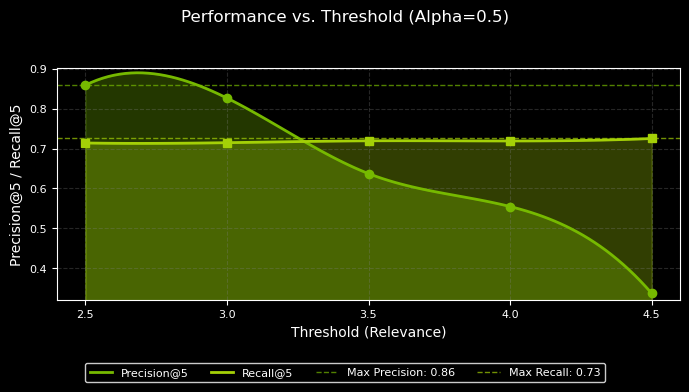

In [10]:
# Benchmark with different thresholds
thresh_values = [2.5, 3.0, 3.5, 4.0, 4.5]
precision_values = []
recall_values = []
rmse_values = []
for thresh in thresh_values:
    precision_at_5, recall_at_5, rmse = precision_recall_at_k(user_test_predictions, recommender.user_rated_movies, alpha=0.5, k=5, threshold=thresh)
    print(f"Threshold: {thresh}")
    print(f"Precision@5: {precision_at_5:.4f}")
    print(f"Recall@5: {recall_at_5:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print()
    precision_values.append(precision_at_5)
    recall_values.append(recall_at_5)
    rmse_values.append(rmse)

# Plot threshold performance
thresh_values = np.array(thresh_values)
precision_values = np.array(precision_values)
recall_values = np.array(recall_values)
thresh_fine = np.linspace(min(thresh_values), max(thresh_values), 100)
spline_precision = make_interp_spline(thresh_values, precision_values, k=3)
spline_recall = make_interp_spline(thresh_values, recall_values, k=3)
precision_smooth = spline_precision(thresh_fine)
recall_smooth = spline_recall(thresh_fine)
all_values = np.concatenate([precision_values, recall_values])
y_min = min(all_values) * 0.95
y_max = min(max(all_values) * 1.05, 1.0)
max_precision = max(precision_values)
max_recall = max(recall_values)
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(7, 3.5))
nvidia_green = '#76B900'
nvidia_light_green = '#A4D007'
line1, = ax1.plot(thresh_fine, precision_smooth, linestyle='-', linewidth=2, label='Precision@5', color=nvidia_green)
line2, = ax1.plot(thresh_fine, recall_smooth, linestyle='-', linewidth=2, label='Recall@5', color=nvidia_light_green)
ax1.plot(thresh_values, precision_values, marker='o', markersize=6, linestyle='', color=nvidia_green)
ax1.plot(thresh_values, recall_values, marker='s', markersize=6, linestyle='', color=nvidia_light_green)
ax1.fill_between(thresh_fine, precision_smooth, color=nvidia_green, alpha=0.3)
ax1.fill_between(thresh_fine, recall_smooth, color=nvidia_light_green, alpha=0.3)
ax1.axhline(y=max_precision, color=nvidia_green, linestyle='--', linewidth=1, alpha=0.7, label=f'Max Precision: {max_precision:.2f}')
ax1.axhline(y=max_recall, color=nvidia_light_green, linestyle='--', linewidth=1, alpha=0.7, label=f'Max Recall: {max_recall:.2f}')
ax1.set_xlabel('Threshold (Relevance)', fontsize=10, color='white')
ax1.set_ylabel('Precision@5 / Recall@5', fontsize=10, color='white')
ax1.tick_params(axis='both', labelsize=8, labelcolor='white')
ax1.set_xticks(thresh_values)
ax1.set_xticklabels(thresh_values, color='white')
ax1.set_ylim(y_min, y_max)
ax1.grid(True, linestyle='--', alpha=0.3, color='gray')
fig.suptitle('Performance vs. Threshold (Alpha=0.5)', fontsize=12, color='white', y=0.98)
handles = [line1, line2] + ax1.get_legend_handles_labels()[0][2:]
labels = [h.get_label() for h in handles]
fig.legend(handles, labels, facecolor='black', edgecolor='white', fontsize=8, labelcolor='white', 
           loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4)
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(bottom=0.15)
plt.show()

From above we can see that:
- As threshold increases, the precision drops, this is expected as we are essentially increasing the aggressiveness of the model, ensuring only highly rated movies are recommended. However, we should not use 2.5 as the threshold as it will recommend just about everything.

How can this be applied in real life?
- Users can manually set wide of a selection they should recieve, this should allow them to set the threshold accordingly.

#### Performance against reccomendation size.
If we increase the top-k, will the metrics have the same, worst or better score?

Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 79767.55it/s]


k: 5
Precision@5: 0.8269
Recall@5: 0.7149
RMSE: 3.3771
F1@5: 0.7668



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 78740.76it/s]


k: 10
Precision@10: 0.6106
Recall@10: 0.9650
RMSE: 3.3771
F1@10: 0.7479



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 79095.80it/s]


k: 15
Precision@15: 0.4285
Recall@15: 0.9931
RMSE: 3.3771
F1@15: 0.5987



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 77333.30it/s]


k: 20
Precision@20: 0.3245
Recall@20: 0.9967
RMSE: 3.3771
F1@20: 0.4896



Computing Metrics (alpha=0.5): 100%|██████████| 103839/103839 [00:01<00:00, 79416.91it/s]


k: 25
Precision@25: 0.2608
Recall@25: 0.9981
RMSE: 3.3771
F1@25: 0.4136



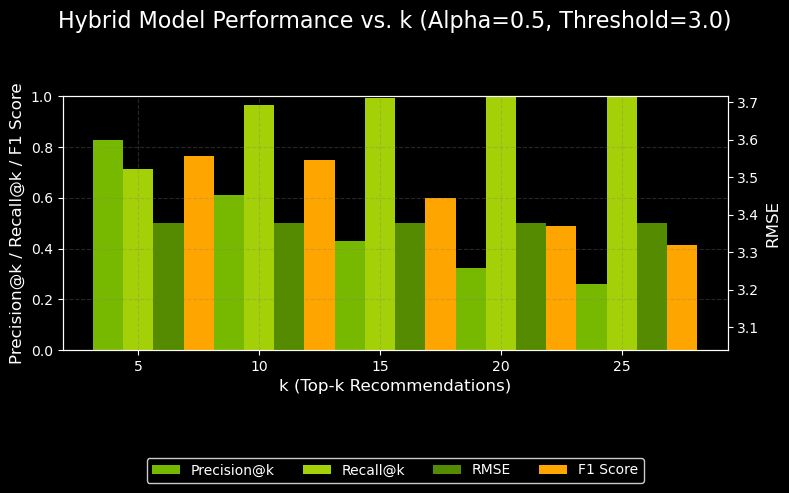

In [11]:
from sklearn.metrics import f1_score

# Benchmark with different k values
k_values = [5, 10, 15, 20, 25]
precision_values = []
recall_values = []
rmse_values = []
f1_values = []

for k in k_values:
    precision_at_k, recall_at_k, rmse = precision_recall_at_k(user_test_predictions, recommender.user_rated_movies, alpha=0.5, k=k, threshold=3.0)
    
    # Calculate F1 score
    f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if precision_at_k + recall_at_k > 0 else 0
    
    print(f"k: {k}")
    print(f"Precision@{k}: {precision_at_k:.4f}")
    print(f"Recall@{k}: {recall_at_k:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"F1@{k}: {f1_at_k:.4f}")
    print()
    
    precision_values.append(precision_at_k)
    recall_values.append(recall_at_k)
    rmse_values.append(rmse)
    f1_values.append(f1_at_k)

# Plot k performance
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(8, 4))
bar_width = 0.25
x = np.arange(len(k_values))
nvidia_green = '#76B900'
nvidia_light_green = '#A4D007'
nvidia_dark_green = '#558B00'
bar1 = ax1.bar(x - bar_width, precision_values, bar_width, label='Precision@k', color=nvidia_green)
bar2 = ax1.bar(x, recall_values, bar_width, label='Recall@k', color=nvidia_light_green)
ax1.set_xlabel('k (Top-k Recommendations)', fontsize=12, color='white')
ax1.set_ylabel('Precision@k / Recall@k', fontsize=12, color='white')
ax1.tick_params(axis='y', labelcolor='white')
ax1.set_xticks(x)
ax1.set_xticklabels(k_values, color='white')
ax1.set_ylim(0, 1)
ax2 = ax1.twinx()
bar3 = ax2.bar(x + bar_width, rmse_values, bar_width, label='RMSE', color=nvidia_dark_green)
ax2.set_ylabel('RMSE', fontsize=12, color='white')
ax2.tick_params(axis='y', labelcolor='white')
ax2.set_ylim(min(rmse_values) * 0.9, max(rmse_values) * 1.1)

# Adding F1 bar
bar4 = ax1.bar(x + 2*bar_width, f1_values, bar_width, label='F1 Score', color='orange')
ax1.set_ylabel('Precision@k / Recall@k / F1 Score', fontsize=12, color='white')

fig.suptitle('Hybrid Model Performance vs. k (Alpha=0.5, Threshold=3.0)', fontsize=16, color='white', y=1.05)
ax1.grid(True, linestyle='--', alpha=0.3, color='gray')
handles = [bar1, bar2, bar3, bar4]
labels = [h.get_label() for h in handles]
fig.legend(handles, labels, facecolor='black', edgecolor='white', fontsize=10, labelcolor='white', 
           loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4)
for ax in [ax1, ax2]:
    ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
plt.tight_layout(rect=[0, 0.2, 1, 0.98])
plt.subplots_adjust(bottom=0.2)
plt.show()


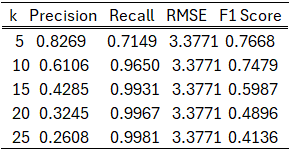




**Precision:**

- Precision is the ratio of relevant recommended items (movies in this case) to the total number of items recommended. It tells us how many of the top k recommended movies are relevant to the user.

- A higher precision means the system is recommending relevant movies more often.
For example, at k = 5, the precision is 0.8269, meaning approximately 82.69% of the top 5 recommendations are relevant.

**Recall:**

- Recall is the ratio of relevant recommended items to the total number of relevant items available for the user. It reflects how well the system captures the relevant items in its recommendations.

- A higher recall means the system is capturing a larger portion of the relevant movies.

- At k = 5, the recall is 0.7149, meaning 71.49% of the relevant items for the user are included in the top 5 recommendations.
RMSE (Root Mean Squared Error):

**RMSE:** 

- It is a measure of the prediction accuracy of the recommendation system.

- Lower RMSE values indicate better prediction accuracy.

- RMSE is consistent across all values of k (3.3771), which suggests that the model's prediction accuracy doesn't vary with the number of top recommendations considered.


**F1 Score:** 

- It is the harmonic mean of precision and recall. It provides a balance between precision and recall, particularly useful when you need to balance both aspects in the context of recommendations.

- A higher F1 score indicates a better balance between precision and recall.

- For k = 5, the F1 score is 0.7668, indicating that there is a good balance between precision and recall in the top 5 recommendations.